In [1]:
# === 1. IMPORTAÇÕES NECESSÁRIAS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                             roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
# === 2. CARREGAMENTO DO DATASET ===
df = pd.read_csv('playground-series-s4e1/train.csv')

In [3]:
# === 3. ANÁLISE EXPLORATÓRIA INICIAL ===
print(df.info())
print(df.isnull().sum())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB
None
id                 0
CustomerId         0
Surname            0
Credit

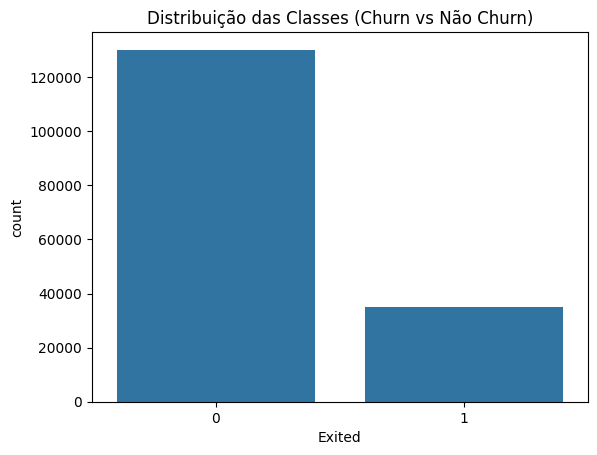

In [4]:
# === 4. DISTRIBUIÇÃO DA VARIÁVEL ALVO ===
sns.countplot(x='Exited', data=df)
plt.title('Distribuição das Classes (Churn vs Não Churn)')
plt.show()

In [5]:
# === 5. PRÉ-PROCESSAMENTO ===
labelencoder = LabelEncoder()
df['Gender'] = labelencoder.fit_transform(df['Gender'])
df['Geography'] = labelencoder.fit_transform(df['Geography'])

X = df.drop('Exited', axis=1)
y = df['Exited']
X = X.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

C:\Users\lara2\AppData\Local\Temp\ipykernel_3120\1461024078.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=selector.scores_[selected_features_mask][sorted_idx],


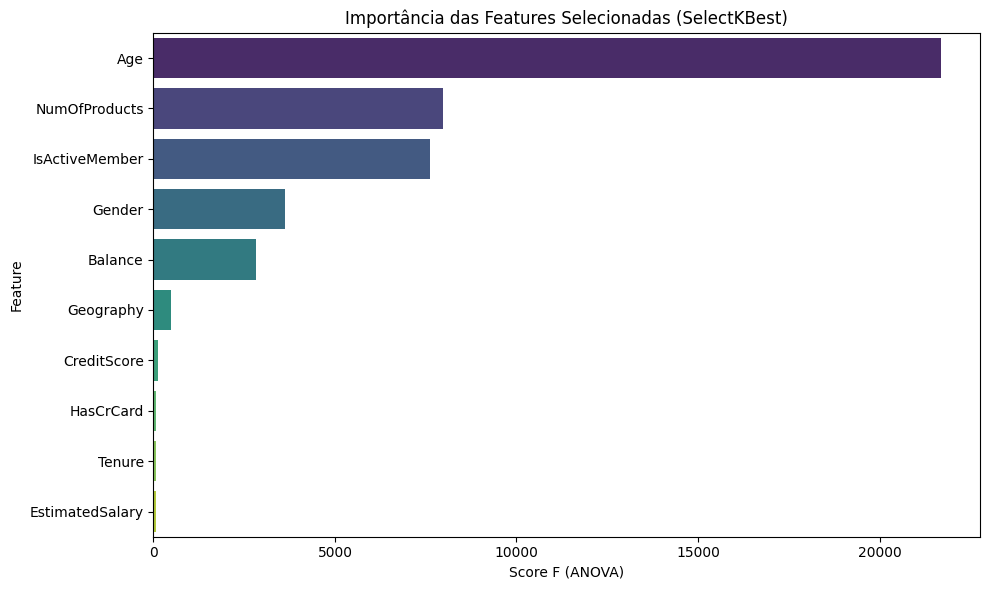

In [6]:
# === 6. SELEÇÃO DE FEATURES ===
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)
selected_features_mask = selector.get_support()
selected_feature_names = X.columns[selected_features_mask]

# Gráfico de importância das features:
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(selector.scores_[selected_features_mask])[::-1]
sns.barplot(x=selector.scores_[selected_features_mask][sorted_idx], 
            y=selected_feature_names[sorted_idx], palette="viridis")
plt.title("Importância das Features Selecionadas (SelectKBest)")
plt.xlabel("Score F (ANOVA)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Resultado: Mostra quais variáveis têm maior poder preditivo segundo ANOVA-F.

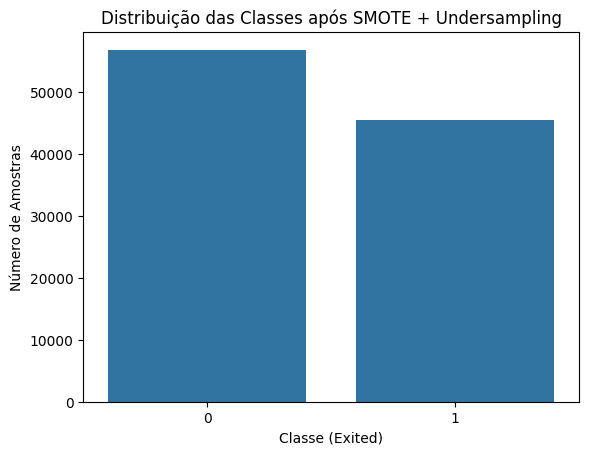

In [7]:
# === 7. DIVISÃO E BALANCEAMENTO ===
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Rebalanceamento com SMOTE + UnderSampling
smote = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.8, random_state=42)
pipeline = Pipeline([('o', smote), ('u', under)])
X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train, y_train)

# Gráfico atualizado da distribuição
sns.countplot(x=y_train_balanced)
plt.title('Distribuição das Classes após SMOTE + Undersampling')
plt.xlabel('Classe (Exited)')
plt.ylabel('Número de Amostras')
plt.show()

# Resultado: Classes mais equilibradas para melhor aprendizagem do modelo.

In [8]:
# === 8. TREINO E AVALIAÇÃO DOS MODELOS ===

## --- Decision Tree ---
param_grid_dt = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train_balanced, y_train_balanced)
y_pred_dt = grid_dt.best_estimator_.predict(X_test)

## --- k-NN ---
param_grid_knn = {'n_neighbors': [11,15,21], 'weights': ['uniform', 'distance'], 'metric': ['euclidean']}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train_balanced, y_train_balanced)
y_pred_knn = grid_knn.best_estimator_.predict(X_test)

## --- SVM ---
param_dist_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
random_svm = RandomizedSearchCV(SVC(probability=True), param_distributions=param_dist_svm,
                                n_iter=6, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
random_svm.fit(X_train_balanced, y_train_balanced)
y_pred_svm = random_svm.best_estimator_.predict(X_test)


Decision Tree Classification Report:
              precision    recall  f1-score   support

    No Churn       0.92      0.86      0.89     39133
       Churn       0.58      0.72      0.64     10378

    accuracy                           0.83     49511
   macro avg       0.75      0.79      0.77     49511
weighted avg       0.85      0.83      0.84     49511



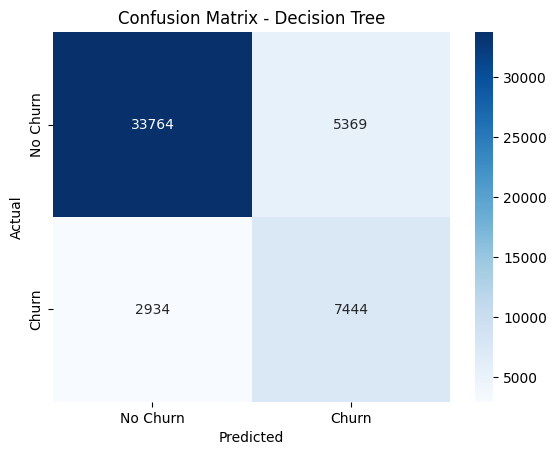


k-NN Classification Report:
              precision    recall  f1-score   support

    No Churn       0.92      0.82      0.87     39133
       Churn       0.52      0.73      0.61     10378

    accuracy                           0.80     49511
   macro avg       0.72      0.78      0.74     49511
weighted avg       0.84      0.80      0.81     49511



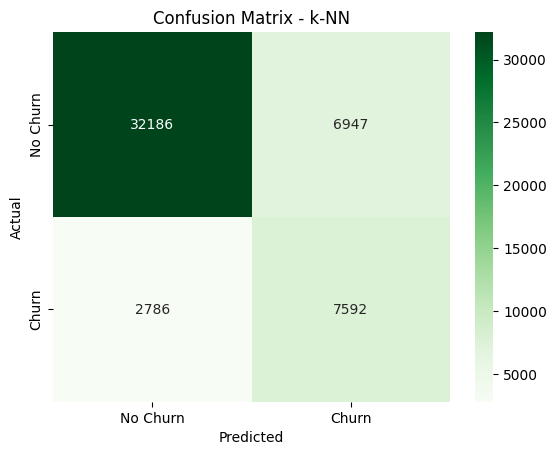


SVM Classification Report:
              precision    recall  f1-score   support

    No Churn       0.93      0.85      0.89     39133
       Churn       0.57      0.75      0.65     10378

    accuracy                           0.83     49511
   macro avg       0.75      0.80      0.77     49511
weighted avg       0.85      0.83      0.84     49511



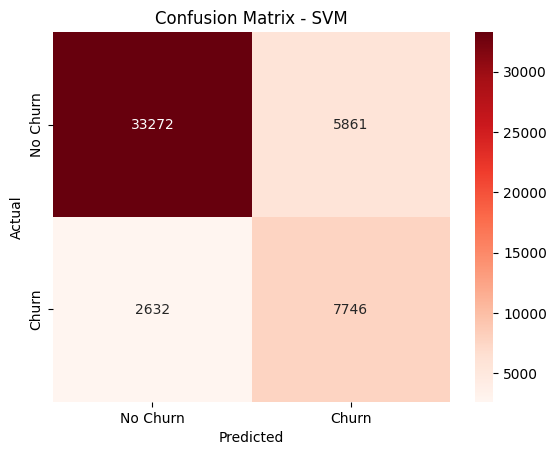

In [9]:
# === 9. RELATÓRIOS DE CLASSIFICAÇÃO E MATRIZES ===
def plot_confusion_and_report(y_true, y_pred, model_name, color):
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["No Churn", "Churn"]))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=color, xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_and_report(y_test, y_pred_dt, "Decision Tree", "Blues")
plot_confusion_and_report(y_test, y_pred_knn, "k-NN", "Greens")
plot_confusion_and_report(y_test, y_pred_svm, "SVM", "Reds")

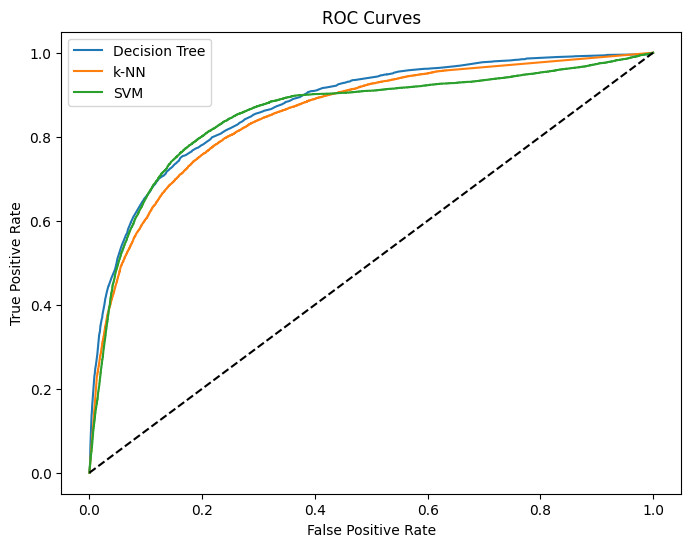

In [10]:
# === 10. CURVAS ROC ===
y_prob_dt = grid_dt.best_estimator_.predict_proba(X_test)[:, 1]
y_prob_knn = grid_knn.best_estimator_.predict_proba(X_test)[:, 1]
y_prob_svm = random_svm.best_estimator_.predict_proba(X_test)[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)

plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, label='Decision Tree')
plt.plot(fpr_knn, tpr_knn, label='k-NN')
plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Resultado: Mostra a capacidade dos modelos distinguirem entre classes, independentemente do threshold.

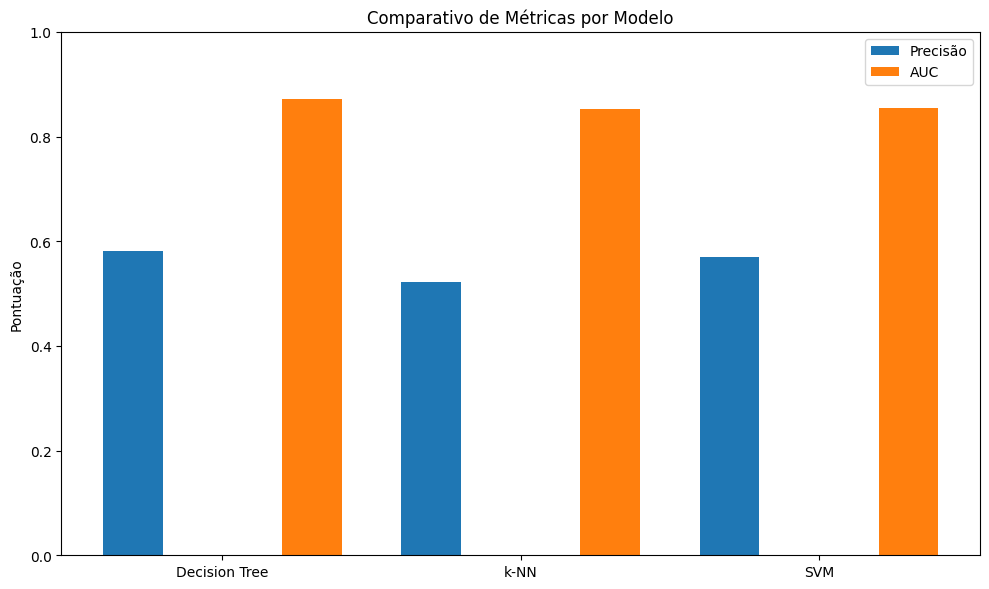

In [11]:
# === 11. COMPARAÇÃO DE MÉTRICAS ===
models = ['Decision Tree', 'k-NN', 'SVM']
precisions = [precision_score(y_test, y_pred_dt), precision_score(y_test, y_pred_knn), precision_score(y_test, y_pred_svm)]
recalls = [recall_score(y_test, y_pred_dt), recall_score(y_test, y_pred_knn), recall_score(y_test, y_pred_svm)]
f1s = [f1_score(y_test, y_pred_dt), f1_score(y_test, y_pred_knn), f1_score(y_test, y_pred_svm)]
aucs = [roc_auc_score(y_test, y_prob_dt), roc_auc_score(y_test, y_prob_knn), roc_auc_score(y_test, y_prob_svm)]

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - 1.5*width, precisions, width, label='Precisão')
#ax.bar(x - 0.5*width, recalls, width, label='Recall')
#ax.bar(x + 0.5*width, f1s, width, label='F1-Score')
ax.bar(x + 1.5*width, aucs, width, label='AUC')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.set_ylabel('Pontuação')
ax.set_title('Comparativo de Métricas por Modelo')
ax.legend()
plt.tight_layout()
plt.show()

# Resultado: Permite escolher o modelo mais equilibrado, especialmente para a classe minoritária (churn).

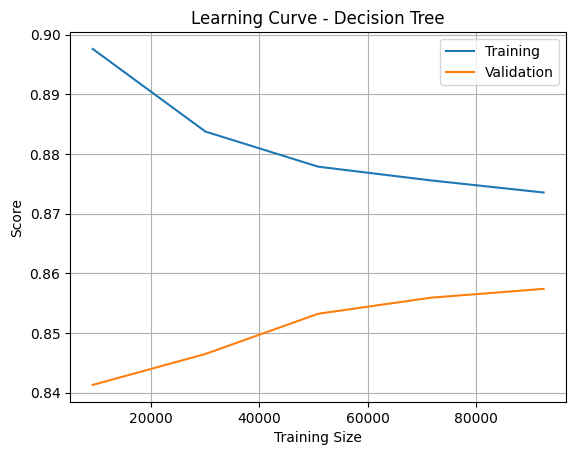

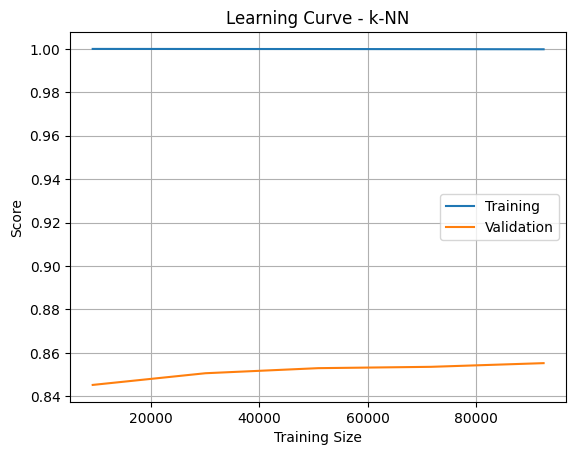

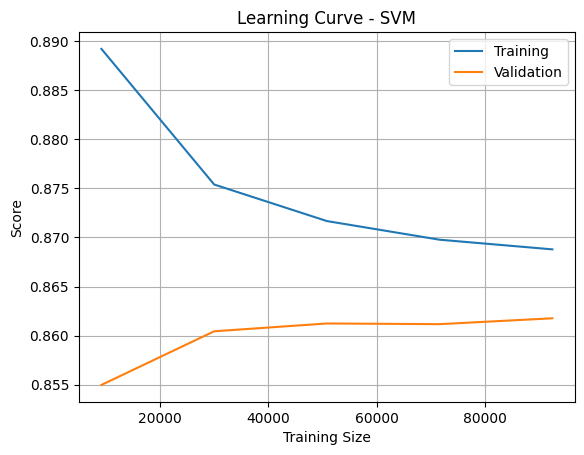

In [12]:
# === 12. CURVAS DE APRENDIZAGEM ===
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, n_jobs=-1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation')
    plt.title(title)
    plt.xlabel('Training Size')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curve(grid_dt.best_estimator_, X_train, y_train, "Learning Curve - Decision Tree")
plot_learning_curve(grid_knn.best_estimator_, X_train, y_train, "Learning Curve - k-NN")
plot_learning_curve(random_svm.best_estimator_, X_train, y_train, "Learning Curve - SVM")

# Resultado: Avalia se o modelo sofre de overfitting ou underfitting conforme cresce o conjunto de treino.

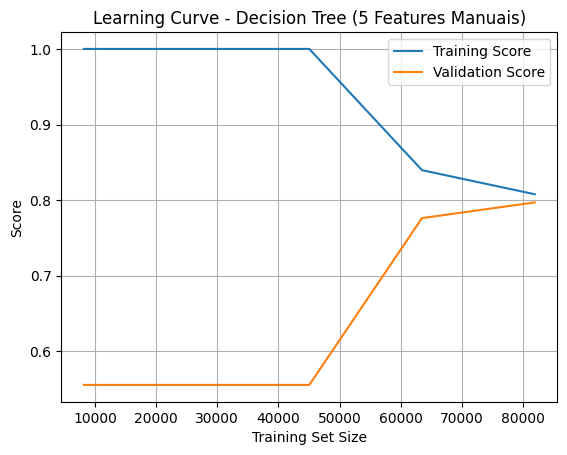


🔍 k-NN (com 5 features manuais):
              precision    recall  f1-score   support

    No Churn       0.87      0.88      0.87     39133
       Churn       0.52      0.51      0.52     10378

    accuracy                           0.80     49511
   macro avg       0.70      0.69      0.69     49511
weighted avg       0.80      0.80      0.80     49511



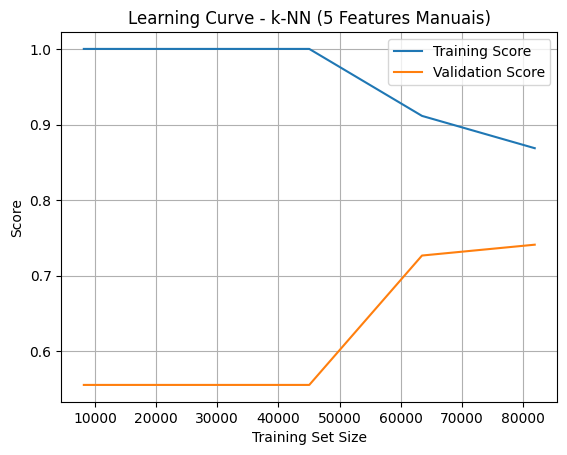

c:\Users\lara2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lara2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lara2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lara2\AppDat

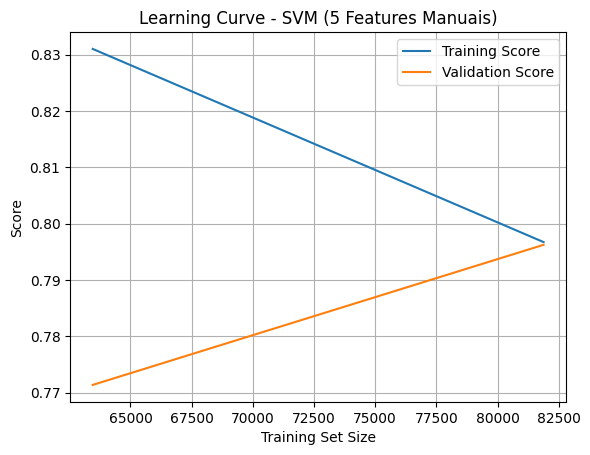

In [16]:
# === Teste alternativo com 5 features manuais ===
selected_manual_features = ['Age', 'NumOfProducts', 'IsActiveMember', 'Gender', 'Balance']

# Importante: garantir que X é um DataFrame original (não normalizado ainda)
X_manual = df[selected_manual_features]
y_manual = df['Exited']

# Normalizar os dados
scaler_manual = StandardScaler()
X_manual_scaled = scaler_manual.fit_transform(X_manual)

# Separar treino e teste
X_train_manual, X_test_manual, y_train_manual, y_test_manual = train_test_split(
    X_manual_scaled, y_manual, test_size=0.3, random_state=42
)

# Rebalanceamento com SMOTE + UnderSampler
from imblearn.pipeline import Pipeline
over = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.8, random_state=42)
pipeline = Pipeline([('o', over), ('u', under)])
X_train_manual_balanced, y_train_manual_balanced = pipeline.fit_resample(X_train_manual, y_train_manual)


# --- Decision Tree ---
param_grid_dt = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5], 'criterion': ['gini', 'entropy']}
grid_dt_manual = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt_manual.fit(X_train_manual_balanced, y_train_manual_balanced)

# Learning Curve DT
train_sizes_dt, train_scores_dt, test_scores_dt = learning_curve(
    grid_dt_manual.best_estimator_,
    X_train_manual_balanced,
    y_train_manual_balanced,
    cv=5,
    n_jobs=-1
)

plt.plot(train_sizes_dt, np.mean(train_scores_dt, axis=1), label='Training Score')
plt.plot(train_sizes_dt, np.mean(test_scores_dt, axis=1), label='Validation Score')
plt.title("Learning Curve - Decision Tree (5 Features Manuais)")
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

# k-NN com GridSearch (valores maiores de k)
param_grid_knn_manual = {
    'n_neighbors': [11, 15, 21],
    'weights': ['distance'],
    'metric': ['euclidean']
}
grid_knn_manual = GridSearchCV(KNeighborsClassifier(), param_grid_knn_manual, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn_manual.fit(X_train_manual_balanced, y_train_manual_balanced)

# Avaliar no conjunto de teste original
y_pred_knn_manual = grid_knn_manual.best_estimator_.predict(X_test_manual)

print("\n🔍 k-NN (com 5 features manuais):")
print(classification_report(y_test_manual, y_pred_knn_manual, target_names=["No Churn", "Churn"]))

# === Curva de Aprendizagem com essas 5 features ===
from sklearn.model_selection import learning_curve

train_sizes_manual, train_scores_manual, test_scores_manual = learning_curve(
    grid_knn_manual.best_estimator_,
    X_train_manual_balanced,
    y_train_manual_balanced,
    cv=5,
    n_jobs=-1
)

plt.plot(train_sizes_manual, np.mean(train_scores_manual, axis=1), label='Training Score')
plt.plot(train_sizes_manual, np.mean(test_scores_manual, axis=1), label='Validation Score')
plt.title("Learning Curve - k-NN (5 Features Manuais)")
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

# --- SVM ---
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['rbf'], 'gamma': ['scale']}
grid_svm_manual = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm_manual.fit(X_train_manual_balanced, y_train_manual_balanced)

"""Learning Curve SVM
train_sizes_svm, train_scores_svm, test_scores_svm = learning_curve(
    grid_svm_manual.best_estimator_,
    X_train_manual_balanced,
    y_train_manual_balanced,
    cv=5,
    n_jobs=-1
)

plt.plot(train_sizes_svm, np.mean(train_scores_svm, axis=1), label='Training Score')
plt.plot(train_sizes_svm, np.mean(test_scores_svm, axis=1), label='Validation Score')
plt.title("Learning Curve - SVM (5 Features Manuais)")
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()"""



🔍 SVM (com 5 features manuais):
              precision    recall  f1-score   support

    No Churn       0.93      0.83      0.88     39133
       Churn       0.54      0.75      0.63     10378

    accuracy                           0.82     49511
   macro avg       0.73      0.79      0.75     49511
weighted avg       0.85      0.82      0.83     49511



c:\Users\lara2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lara2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lara2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lara2\AppDat

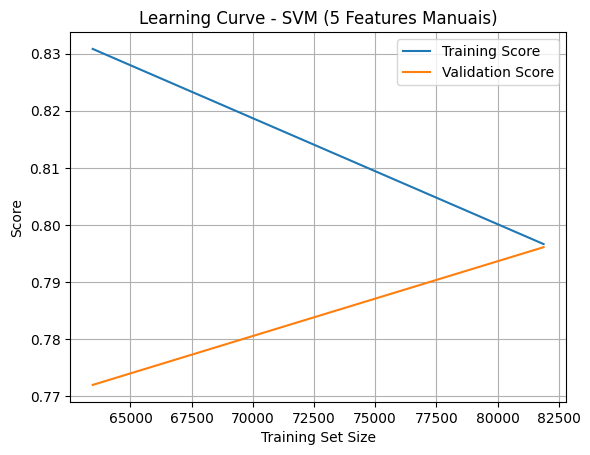

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# Grid de hiperparâmetros
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': ['scale']
}

# Estratégia de validação estratificada (mantém proporção entre classes)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch com SVM
grid_svm_manual = GridSearchCV(
    SVC(probability=True),
    param_grid_svm,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1
)

# Treinar com dados balanceados
grid_svm_manual.fit(X_train_manual_balanced, y_train_manual_balanced)

# Avaliar no conjunto de teste original
y_pred_svm_manual = grid_svm_manual.best_estimator_.predict(X_test_manual)

# Relatório de classificação
print("\n🔍 SVM (com 5 features manuais):")
print(classification_report(y_test_manual, y_pred_svm_manual, target_names=["No Churn", "Churn"]))

# Curva de aprendizagem
train_sizes_svm, train_scores_svm, test_scores_svm = learning_curve(
    grid_svm_manual.best_estimator_,
    X_train_manual_balanced,
    y_train_manual_balanced,
    cv=cv_strategy,
    n_jobs=-1
)

plt.plot(train_sizes_svm, np.mean(train_scores_svm, axis=1), label='Training Score')
plt.plot(train_sizes_svm, np.mean(test_scores_svm, axis=1), label='Validation Score')
plt.title("Learning Curve - SVM (5 Features Manuais)")
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# === 13. MELHORES PARÂMETROS ===
print("\nBest Parameters:")
print("Decision Tree:", grid_dt.best_params_)
print("k-NN:", grid_knn.best_params_)
print("SVM:", random_svm.best_params_)


Best Parameters:
Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}
k-NN: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
SVM: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}


In [15]:
# === 14. Visualização dos resultados do GridSearchCV como tabela
results_dt = pd.DataFrame(grid_dt.cv_results_)
results_knn = pd.DataFrame(grid_knn.cv_results_)
results_svm = pd.DataFrame(random_svm.cv_results_)

print("\nTop 5 GridSearch Results - Decision Tree")
print(results_dt[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head())

print("\nTop 5 GridSearch Results - k-NN")
print(results_knn[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head())

print("\nTop 5 GridSearch Results - SVM")
print(results_svm[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head())


Top 5 GridSearch Results - Decision Tree
                                               params  mean_test_score
8   {'criterion': 'gini', 'max_depth': 10, 'min_sa...         0.810439
6   {'criterion': 'gini', 'max_depth': 10, 'min_sa...         0.810409
7   {'criterion': 'gini', 'max_depth': 10, 'min_sa...         0.810312
18  {'criterion': 'entropy', 'max_depth': 10, 'min...         0.809022
19  {'criterion': 'entropy', 'max_depth': 10, 'min...         0.808934

Top 5 GridSearch Results - k-NN
                                              params  mean_test_score
1  {'metric': 'euclidean', 'n_neighbors': 11, 'we...         0.842475
3  {'metric': 'euclidean', 'n_neighbors': 15, 'we...         0.839280
5  {'metric': 'euclidean', 'n_neighbors': 21, 'we...         0.836691
0  {'metric': 'euclidean', 'n_neighbors': 11, 'we...         0.812735
2  {'metric': 'euclidean', 'n_neighbors': 15, 'we...         0.809071

Top 5 GridSearch Results - SVM
                                             pa